# 1st Data visualisation and web scraping

  * In this task you should download (*scrape*) data from the web, process it and visualise.
  * The objective is to download data from server https://www.psp.cz/en/sqw/hlasovani.sqw?o=8 regarding voting in the Chamber of Deputies of the Parliament of the Czech Republic, save it in a tabular form and create visualisations, which make exploration of the data easier and show interesting information about it.

## Data

 * Download data from all votings of the current Chamber of Deputies (since 2017). Download details of voting of particular deputies.
 * Data should contain basic information about the voting - number of meeting, number of voting, point of the meeting and date.

## Instructions


**Basic points of the assignment**:
  * Write Python script for downloading data. Download the data and save it in a suitable machine-readable format.
  * **Wait at least 1 second between two consecutive requests to the server, to not overload it.**
  * In the second part of the notebook, work with the data loaded from a local file. File(s) with downloaded data should be submitted as well (so the reviewer do not have to download the data again).
  * Create visualisations to show the following:
    * Deputies changing their parliamentary clubs.
    * Attendance of individual deputies in the votings. Attendance of parliamentary clubs in the votings.
    * How often individual parliamentary clubs vote the same and different.
    * Are deputies in the same parliamentary club voting the same? Who are the biggest rebels?

  * Visualise some time development in the data (e.g. attendance, change of agreement in voting among individual parliamentary clubs, etc.)
  * Find individual deputies who have the most similar voting or attendance.
  * Try to find particular voting, where deputies voted the most differently than traditionally.
  
## Tips and tricks
  * Import libraries at the beginning of the notebook, or the beginning of scraping and visualisation parts.
  * Use markdown cells (like this one) and headings to make orientation in the notebook easier.
  * Select plots and visualisation matching the information you want to show. You can see galleries of libraries `matplotlib` and `seaborn` for inspiration.


In [2]:
import requests
from requests import get
from bs4 import BeautifulSoup 
import pandas as pd
import numpy as np
from time import sleep
import datetime
from collections import Counter
from random import randint
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from seaborn import countplot
import csv
import re
import os
import glob


#### Getting urls of  62 meetings:

In [3]:
URLs = []

template_url = 'https://www.psp.cz/en/sqw/phlasa.sqw?o=8&s={}&pg=1'
range_first_pages = range(1,63)
for first_page in range_first_pages:
    #if first_page in urls_with_subpages:
    if first_page != 10 and first_page != 21:
        URLs.append(template_url.format(first_page,range_first_pages))            
    else:
        continue

In [4]:
#for i in  URLs:
    #print('URLs:', i)

#### Getting urls of  subpages of each meeting: 

In [9]:
global unique_URLs_next_pages
unique_URLs_next_pages = []

def get_links(root_url):    
    URLs_next_pages = set()    
    while True:        
        r = requests.get(root_url)
        first_link = BeautifulSoup(r.text, 'html.parser')
        base_url = 'https://www.psp.cz/en/sqw/'
        for p_tag in first_link.find_all('p', class_='paging'):
            for a_tag in p_tag.find_all('a', class_=None):
                check_url = a_tag['href']
                if check_url.startswith('phlasa.sqw?o=8'):
                    valid_url = base_url + a_tag['href']
                    URLs_next_pages.add(valid_url)
        next_page = first_link.find('a', class_='next')    
        if next_page:
            next_url = a_tag['href']
            if next_url:
                root_url = base_url + a_tag['href']
            else:
                break
        else:
            URLs_next_pages.add(root_url)
            break
    for element in URLs_next_pages:
        unique_URLs_next_pages.append(element)
        
    return unique_URLs_next_pages

In [10]:
for i in URLs:
    unique_URLs_next_pages = get_links(i)

#### Opening each url of subpages, from which data will be scraped:

In [13]:
global ready_for_scraping
ready_for_scraping = []

def openning_pages_for_scraping(some_urls): 
    
    for url in some_urls:        
        url_links = requests.get(url)
        first_link = BeautifulSoup(url_links.text, 'html.parser') 
        
        url_all_links =[]
        base_url1 = 'https://www.psp.cz/en/sqw/'
        for td in first_link.find_all('td'):
            for a_tag in td.find_all('a', href=True):
                check_url1 = a_tag['href']
                #print("Found the URL:", check_url) 
                if check_url1.startswith('hlasy.sqw?g='):
                    valid_url = base_url1 + a_tag['href']
                    #print(valid_url)
                    ready_for_scraping.append(valid_url)
                else:
                    continue
    return ready_for_scraping 

In [14]:
ready_for_scraping  = openning_pages_for_scraping(unique_URLs_next_pages)
len(ready_for_scraping)

7323

#### The main code for scraping all needed  data from each subpages, the result is saved in dataframe in files HW1_1.csv', 'HW1_2.csv', 'HW1_3.csv', 'HW1_4.csv.



In [7]:
def scraping_data(urls):
   
    meeting_number =[]
    vote_number =[]
    vote_date =[]
    vote_time = []
    agenda =[]   
    vote = []
    clubs =[]
    deputies = []

    for url in urls:
        try:           
            vote_response = requests.get(url)
            sleep(randint(1,4))
            vote_page = BeautifulSoup(vote_response.text, 'html.parser') 

            meeting_number_tag = vote_page.find('h1', class_='page-title-x').next
            number_meeting = meeting_number_tag[:2].replace('.', '')                         
            print(number_meeting)

            number_vote_tag = meeting_number_tag.next
            number_vote = number_vote_tag.text[:3].replace('.', '')                                      
            print(number_vote)

            date_text = number_vote_tag.next.next
            date = date_text.replace(',','')[:-6]
            print(date)
            vote_timee = date_text.replace(',','')[-6:]
            
                
            agenda_meeting_tag = vote_page.h1.find('br')                 
            agenda_meeting = vote_page.h1.find('br').next_sibling
            print(agenda_meeting)

            
            for deputies_vote1 in vote_page.find('ul', class_='results'):
                deputies_vote1_text = deputies_vote1.text.replace('\xa0', '')
                club_vote1 = vote_page.h2.find_next('h2')            
                club1 = club_vote1.text
                name_club1 = re.sub('\(.*?\)', '',club1)
                clubs.append(name_club1) 


                meeting_number.append(number_meeting)
                vote_number.append(number_vote)
                vote_date.append(date)
                vote_time.append(vote_timee)                                  
                agenda.append(agenda_meeting)
                             
                for deputy in deputies_vote1_text[0]:
                    if deputy in 'N':
                        deputies.append(deputies_vote1_text[1:])
                        vote.append('ne')                                        
                    elif deputy in 'A':
                        deputies.append(deputies_vote1_text[1:])
                        vote.append('ano')                
                    elif deputy in '0':  
                        deputies.append(deputies_vote1_text[1:])
                        vote.append('neprihlasen')         
                    elif deputy in 'M':
                        deputies.append(deputies_vote1_text[1:])
                        vote.append('omluven')
                    elif deputy in 'Z':
                        deputies.append(deputies_vote1_text[1:])
                        vote.append('zdrzel')
            
            for deputies_vote2 in deputies_vote1.find_next('ul', class_='results'):
                deputies_vote2_text = deputies_vote2.text.replace('\xa0', '')
                club_vote2 = club_vote1.find_next('h2', class_='section-title center')
                club2 = club_vote2.text               
                name_club2 = re.sub('\(.*?\)', '',club2)
                clubs.append(name_club2) 
               
                meeting_number.append(number_meeting)
                vote_number.append(number_vote)
                vote_date.append(date)
                vote_time.append(vote_timee)                                  
                agenda.append(agenda_meeting)
                             
                for deputy in deputies_vote2_text[0]:
                    if deputy in 'N':
                        deputies.append(deputies_vote2_text[1:])
                        vote.append('ne')                                        
                    elif deputy in 'A':
                        deputies.append(deputies_vote2_text[1:])
                        vote.append('ano')                
                    elif deputy in '0':  
                        deputies.append(deputies_vote2_text[1:])
                        vote.append('neprihlasen')         
                    elif deputy in 'M':
                        deputies.append(deputies_vote2_text[1:])
                        vote.append('omluven')
                    elif deputy in 'Z':
                        deputies.append(deputies_vote2_text[1:])
                        vote.append('zdrzel')
                        
            for deputies_vote3 in deputies_vote2.find_next('ul', class_='results'):
                deputies_vote3_text = deputies_vote3.text.replace('\xa0', '')
                club_vote3 = club_vote2.find_next('h2', class_='section-title center')
                club3 = club_vote3.text              
                name_club3 = re.sub('\(.*?\)', '',club3)
                clubs.append(name_club3) 
             

                
                meeting_number.append(number_meeting)
                vote_number.append(number_vote)
                vote_date.append(date)
                vote_time.append(vote_timee)                                  
                agenda.append(agenda_meeting)
                             
                for deputy in deputies_vote3_text[0]:
                    if deputy in 'N':
                        deputies.append(deputies_vote3_text[1:])
                        vote.append('ne')                                        
                    elif deputy in 'A':
                        deputies.append(deputies_vote3_text[1:])
                        vote.append('ano')                
                    elif deputy in '0':  
                        deputies.append(deputies_vote3_text[1:])
                        vote.append('neprihlasen')         
                    elif deputy in 'M':
                        deputies.append(deputies_vote3_text[1:])
                        vote.append('omluven')
                    elif deputy in 'Z':
                        deputies.append(deputies_vote3_text[1:])
                        vote.append('zdrzel')
                        
            for deputies_vote4 in deputies_vote3.find_next('ul', class_='results'):
                deputies_vote4_text = deputies_vote4.text.replace('\xa0', '')
                club_vote4 = club_vote3.find_next('h2', class_='section-title center')
                club4 = club_vote4.text               
                name_club4 = re.sub('\(.*?\)', '',club4)
                clubs.append(name_club4) 
 
                meeting_number.append(number_meeting)
                vote_number.append(number_vote)
                vote_date.append(date)
                vote_time.append(vote_timee)                                  
                agenda.append(agenda_meeting)
                             
                for deputy in deputies_vote4_text[0]:
                    if deputy in 'N':
                        deputies.append(deputies_vote4_text[1:])
                        vote.append('ne')                                        
                    elif deputy in 'A':
                        deputies.append(deputies_vote4_text[1:])
                        vote.append('ano')                
                    elif deputy in '0':  
                        deputies.append(deputies_vote4_text[1:])
                        vote.append('neprihlasen')         
                    elif deputy in 'M':
                        deputies.append(deputies_vote4_text[1:])
                        vote.append('omluven')
                    elif deputy in 'Z':
                        deputies.append(deputies_vote4_text[1:])
                        vote.append('zdrzel')

            for deputies_vote5 in deputies_vote4.find_next('ul', class_='results'):
                deputies_vote5_text = deputies_vote5.text.replace('\xa0', '')
                club_vote5 = club_vote4.find_next('h2', class_='section-title center')
                club5 = club_vote5.text             
                name_club5 = re.sub('\(.*?\)', '',club5)
                clubs.append(name_club5) 
 
                meeting_number.append(number_meeting)
                vote_number.append(number_vote)
                vote_date.append(date)
                vote_time.append(vote_timee)                                  
                agenda.append(agenda_meeting)
                             
                for deputy in deputies_vote5_text[0]:
                    if deputy in 'N':
                        deputies.append(deputies_vote5_text[1:])
                        vote.append('ne')                                        
                    elif deputy in 'A':
                        deputies.append(deputies_vote5_text[1:])
                        vote.append('ano')                
                    elif deputy in '0':  
                        deputies.append(deputies_vote5_text[1:])
                        vote.append('neprihlasen')         
                    elif deputy in 'M':
                        deputies.append(deputies_vote5_text[1:])
                        vote.append('omluven')
                    elif deputy in 'Z':
                        deputies.append(deputies_vote5_text[1:])
                        vote.append('zdrzel')
             
            for deputies_vote6 in deputies_vote5.find_next('ul', class_='results'):
                deputies_vote6_text = deputies_vote6.text.replace('\xa0', '')
                club_vote6 = club_vote5.find_next('h2', class_='section-title center')
                club6 = club_vote6.text               
                name_club6 = re.sub('\(.*?\)', '',club6)
                clubs.append(name_club6) 

                meeting_number.append(number_meeting)
                vote_number.append(number_vote)
                vote_date.append(date)
                vote_time.append(vote_timee)                                  
                agenda.append(agenda_meeting)
                             
                for deputy in deputies_vote6_text[0]:
                    if deputy in 'N':
                        deputies.append(deputies_vote6_text[1:])
                        vote.append('ne')                                        
                    elif deputy in 'A':
                        deputies.append(deputies_vote6_text[1:])
                        vote.append('ano')                
                    elif deputy in '0':  
                        deputies.append(deputies_vote6_text[1:])
                        vote.append('neprihlasen')         
                    elif deputy in 'M':
                        deputies.append(deputies_vote6_text[1:])
                        vote.append('omluven')
                    elif deputy in 'Z':
                        deputies.append(deputies_vote6_text[1:])
                        vote.append('zdrzel')
                        
            for deputies_vote7 in deputies_vote6.find_next('ul', class_='results'):
                deputies_vote7_text = deputies_vote7.text.replace('\xa0', '')
                club_vote7 = club_vote6.find_next('h2', class_='section-title center')
                club7 = club_vote7.text               
                name_club7 = re.sub('\(.*?\)', '',club7)
                clubs.append(name_club7) 

                meeting_number.append(number_meeting)
                vote_number.append(number_vote)
                vote_date.append(date)
                vote_time.append(vote_timee)                                  
                agenda.append(agenda_meeting)
                             
                for deputy in deputies_vote7_text[0]:
                    if deputy in 'N':
                        deputies.append(deputies_vote7_text[1:])
                        vote.append('ne')                                        
                    elif deputy in 'A':
                        deputies.append(deputies_vote7_text[1:])
                        vote.append('ano')                
                    elif deputy in '0':  
                        deputies.append(deputies_vote7_text[1:])
                        vote.append('neprihlasen')         
                    elif deputy in 'M':
                        deputies.append(deputies_vote7_text[1:])
                        vote.append('omluven')
                    elif deputy in 'Z':
                        deputies.append(deputies_vote7_text[1:])
                        vote.append('zdrzel')
                        
            for deputies_vote8 in deputies_vote7.find_next('ul', class_='results'):
                deputies_vote8_text = deputies_vote8.text.replace('\xa0', '')
                club_vote8 = club_vote7.find_next('h2', class_='section-title center')
                club8 = club_vote8.text               
                name_club8 = re.sub('\(.*?\)', '',club8)
                clubs.append(name_club8) 

                meeting_number.append(number_meeting)
                vote_number.append(number_vote)
                vote_date.append(date)
                vote_time.append(vote_timee)                                  
                agenda.append(agenda_meeting)
                             
                for deputy in deputies_vote8_text[0]:
                    if deputy in 'N':
                        deputies.append(deputies_vote8_text[1:])
                        vote.append('ne')                                        
                    elif deputy in 'A':
                        deputies.append(deputies_vote8_text[1:])
                        vote.append('ano')                
                    elif deputy in '0':  
                        deputies.append(deputies_vote8_text[1:])
                        vote.append('neprihlasen')         
                    elif deputy in 'M':
                        deputies.append(deputies_vote8_text[1:])
                        vote.append('omluven')
                    elif deputy in 'Z':
                        deputies.append(deputies_vote8_text[1:])
                        vote.append('zdrzel')
                        
            for deputies_vote9 in deputies_vote8.find_next('ul', class_='results'):
                deputies_vote9_text = deputies_vote9.text.replace('\xa0', '')
                club_vote9 = club_vote8.find_next('h2', class_='section-title center')
                club9 = club_vote9.text               
                name_club9 = re.sub('\(.*?\)', '',club9)
                clubs.append(name_club9) 

                meeting_number.append(number_meeting)
                vote_number.append(number_vote)
                vote_date.append(date)
                vote_time.append(vote_timee)                                  
                agenda.append(agenda_meeting)
                             
                for deputy in deputies_vote9_text[0]:
                    if deputy in 'N':
                        deputies.append(deputies_vote9_text[1:])
                        vote.append('ne')                                        
                    elif deputy in 'A':
                        deputies.append(deputies_vote9_text[1:])
                        vote.append('ano')                
                    elif deputy in '0':  
                        deputies.append(deputies_vote9_text[1:])
                        vote.append('neprihlasen')         
                    elif deputy in 'M':
                        deputies.append(deputies_vote9_text[1:])
                        vote.append('omluven')
                    elif deputy in 'Z':
                        deputies.append(deputies_vote9_text[1:])
                        vote.append('zdrzel')
            try:            
                for deputies_vote10 in deputies_vote9.find_next('ul', class_='results'):
                    deputies_vote10_text = deputies_vote10.text.replace('\xa0', '')
                    club_vote10 = club_vote9.find_next('h2', class_='section-title center')
                    club10 = club_vote10.text               
                    name_club10 = re.sub('\(.*?\)', '',club10)
                    clubs.append(name_club10) 

                    meeting_number.append(number_meeting)
                    vote_number.append(number_vote)
                    vote_date.append(date)
                    vote_time.append(vote_timee)                                  
                    agenda.append(agenda_meeting)

                    for deputy in deputies_vote10_text[0]:
                        if deputy in 'N':
                            deputies.append(deputies_vote10_text[1:])
                            vote.append('ne')                                        
                        elif deputy in 'A':
                            deputies.append(deputies_vote10_text[1:])
                            vote.append('ano')                
                        elif deputy in '0':  
                            deputies.append(deputies_vote10_text[1:])
                            vote.append('neprihlasen')         
                        elif deputy in 'M':
                            deputies.append(deputies_vote10_text[1:])
                            vote.append('omluven')
                        elif deputy in 'Z':
                            deputies.append(deputies_vote10_text[1:])
                            vote.append('zdrzel')
                            
            except:
                pass            
        
               
            Data = pd.DataFrame({ 
                'meeting_no': pd.Series(meeting_number, dtype=pd.StringDtype()),
                'vote_no': pd.Series(vote_number,dtype=pd.StringDtype()),
                'vote_date': pd.Series(vote_date,dtype=pd.StringDtype()),
                'vote_time': pd.Series(vote_time,dtype=pd.StringDtype()),
                'agenda': pd.Series(agenda,dtype=pd.StringDtype()),
                'clubs':pd.Series(clubs,dtype=pd.StringDtype()),
                'deputies': pd.Series(deputies,dtype=pd.StringDtype()),
                'vote': pd.Series(vote,dtype=pd.StringDtype()),    
                })

            Data['meeting_no'],
            Data['vote_no'],
            Data['vote_date'],
            Data['vote_time']
            Data['agenda'],
            Data['clubs']
            Data['deputies'],    
            Data['vote']

            print('Ok')
            Data.to_csv('HW1_4.csv', index=False)
        except:
            print('Cannot open page')
            continue

In [ ]:
scraping_data(ready_for_scraping)

1

Cannot open page
1
2 
 20. listopadu 2017
Inf. o ustavení volební komise PS a volbě členů
Ok
1
3 
 20. listopadu 2017
None
Ok
1
4 
 20. listopadu 2017
Náv.na stanovení počtu čl. MIV
Ok
1
5 
 20. listopadu 2017
Náv.na stanovení počtu čl. MIV
Ok
1
6 
 22. listopadu 2017
Návrh na ustavení MIV
Ok
1
7 
 22. listopadu 2017
Návrh na potvrzení předsedy MIV
Ok
1
8 
 22. listopadu 2017
Inf. MIV o ověření platnosti volby poslanců
Ok
1
9 
 22. listopadu 2017
Návrh na stanovení počtu místopředsedů PS
Ok
1
10
 22. listopadu 2017
Návrh na stanovení počtu místopředsedů PS
Ok
1
11
 24. listopadu 2017
Návrh na stanovení počtu ověřovatelů PS
Ok
1
12
 24. listopadu 2017
Návrh na nominaci ověřovatelů PS
Ok
1
13
 24. listopadu 2017
Návrh na nominaci ověřovatelů PS
Ok
1
14
 24. listopadu 2017
Návrh na zřízení výborů PS
Ok
1
15
 24. listopadu 2017
Návrh na stanovení počtu členů výborů PS
Ok
1
16
 24. listopadu 2017
Návrh termínu 2. schůze PS
Ok
2
1 
 28. listopadu 2017
None
Ok
2
2 
 28. listopadu 2017
Pořa

4
96
 19. prosince 2017
Vl.n.z. o státním rozpočtu ČR na rok 2018
Ok
4
97
 19. prosince 2017
Vl.n.z. o státním rozpočtu ČR na rok 2018
Ok
4
98
 19. prosince 2017
Vl.n.z. o státním rozpočtu ČR na rok 2018
Ok
4
99
 19. prosince 2017
Vl.n.z. o státním rozpočtu ČR na rok 2018
Ok
4
100
 19. prosince 2017
Vl.n.z. o státním rozpočtu ČR na rok 2018
Ok
4
61
 19. prosince 2017
Vl.n.z. o státním rozpočtu ČR na rok 2018
Ok
4
62
 19. prosince 2017
Vl.n.z. o státním rozpočtu ČR na rok 2018
Ok
4
63
 19. prosince 2017
Vl.n.z. o státním rozpočtu ČR na rok 2018
Ok
4
64
 19. prosince 2017
Vl.n.z. o státním rozpočtu ČR na rok 2018
Ok
4
65
 19. prosince 2017
Vl.n.z. o státním rozpočtu ČR na rok 2018
Ok
4
66
 19. prosince 2017
Vl.n.z. o státním rozpočtu ČR na rok 2018
Ok
4
67
 19. prosince 2017
Vl.n.z. o státním rozpočtu ČR na rok 2018
Ok
4
68
 19. prosince 2017
Vl.n.z. o státním rozpočtu ČR na rok 2018
Ok
4
69
 19. prosince 2017
Vl.n.z. o státním rozpočtu ČR na rok 2018
Ok
4
70
 19. prosince 2017
Vl.n.z. o

Ok
6
26
 18. ledna 2018
Novela z. o ochraně ovzduší - EU
Ok
6
27
 19. ledna 2018
Pořad schůze
Ok
6
28
 19. ledna 2018
Návrh na volbu členů nebo ustavení SK ÚZSI
Ok
6
29
 19. ledna 2018
Žádost o vyslovení souhlasu s tr. stíháním poslanců
Ok
6
30
 19. ledna 2018
Žádost o vyslovení souhlasu s tr. stíháním poslanců
Ok
6
31
 23. ledna 2018
Pořad schůze
Ok
6
32
 23. ledna 2018
Pořad schůze
Ok
6
33
 23. ledna 2018
Pořad schůze
Ok
6
34
 23. ledna 2018
Novela z. - zákoník práce
Ok
6
35
 23. ledna 2018
Návrh Pravidel hospodaření poslaneckých klubů pro rok 2018
Ok
6
36
 23. ledna 2018
Vl. n. z. o podmínkách využív. gen. zdrojů podle Nagoj. prot. - EU
Ok
6
37
 23. ledna 2018
Vl. n. z. o podmínkách využív. gen. zdrojů podle Nagoj. prot. - EU
Ok
6
38
 23. ledna 2018
Vl. n. z. o podmínkách využív. gen. zdrojů podle Nagoj. prot. - EU
Ok
6
39
 23. ledna 2018
Vl. n. z. o podmínkách využív. gen. zdrojů podle Nagoj. prot. - EU
Ok
6
40
 23. ledna 2018
Novela z. o evidenci obyvatel
Ok
6
61
 24. ledna 2018
Ž

Ok
7
92
 20. března 2018
Vl.n.z.o poskyt.st.záruky ČR na zajištění půjčky ČNB pro MMF
Ok
7
93
 20. března 2018
N. z. o činnosti inst. zaměstnaneckého penzijního pojištění - EU
Ok
7

Cannot open page
7

Cannot open page
7
96
 20. března 2018
Novela z. o vývozu a dovozu zboží - EU
Ok
7
97
 20. března 2018
Novela z. - insolvenční zákon - EU
Ok
7
98
 20. března 2018
Novela z. - insolvenční zákon - EU
Ok
7
99
 20. března 2018
Novela z. - insolvenční zákon - EU
Ok
7
100
 20. března 2018
Novela z. - insolvenční zákon - EU
Ok
7
41
 1. března 2018
Novela z. - trestní zákoník
Ok
7
42
 2. března 2018
Pořad schůze
Ok
7
43
 2. března 2018
Pořad schůze
Ok
7
44
 2. března 2018
Návrh na volbu předsedy SK pro kontrolu činnosti GIBS
Ok
7
45
 2. března 2018
Novela z. - správní řád
Ok
7
46
 2. března 2018
Novela z. - správní řád
Ok
7
47
 2. března 2018
Novela z. o volbách do Parlamentu ČR
Ok
7
48
 2. března 2018
Novela z. o volbách do Parlamentu ČR
Ok
7
49
 2. března 2018
Novela z. o volbách do Parlamentu

Ok
12
62
 13. dubna 2018
Novela z. o pomoci v hmotné nouzi
Ok
12
63
 13. dubna 2018
Novela z. o pomoci v hmotné nouzi
Ok
12
64
 13. dubna 2018
Novela z. o pomoci v hmotné nouzi
Ok
12

Cannot open page
12
66
 13. dubna 2018
Novela z. o volbách do Parlamentu ČR
Ok
12
67
 17. dubna 2018
Pořad schůze
Ok
12
68
 17. dubna 2018
Pořad schůze
Ok
12
69
 17. dubna 2018
Pořad schůze
Ok
12
70
 17. dubna 2018
Pořad schůze
Ok
12
71
 17. dubna 2018
Pořad schůze
Ok
12
72
 17. dubna 2018
Pořad schůze
Ok
12
73
 17. dubna 2018
Pozice vlády České republiky k událostem v Sýrii
Ok
12
74
 17. dubna 2018
Pozice vlády České republiky k událostem v Sýrii
Ok
12
75
 17. dubna 2018
Pozice vlády České republiky k událostem v Sýrii
Ok
12
76
 17. dubna 2018
Pozice vlády České republiky k událostem v Sýrii
Ok
12
77
 17. dubna 2018
Pozice vlády České republiky k událostem v Sýrii
Ok
12
78
 17. dubna 2018
Pozice vlády České republiky k událostem v Sýrii
Ok
12
79
 17. dubna 2018
Pozice vlády České republiky k událostem v 

Ok
13
3 
 22. května 2018
Pořad schůze
Ok
13
4 
 22. května 2018
Pořad schůze
Ok
13
5 
 22. května 2018
Pořad schůze
Ok
13
6 
 22. května 2018
Pořad schůze
Ok
13
7 
 22. května 2018
Pořad schůze
Ok
13
8 
 22. května 2018
Pořad schůze
Ok
13
9 
 22. května 2018
Pořad schůze
Ok
13
10
 22. května 2018
Pořad schůze
Ok
13
11
 22. května 2018
Pořad schůze
Ok
13
12
 22. května 2018
Pořad schůze
Ok
13
13
 22. května 2018
Pořad schůze
Ok
13
14
 22. května 2018
Pořad schůze
Ok
13
15
 22. května 2018
Pořad schůze
Ok
13
16
 22. května 2018
Pořad schůze
Ok
13
17
 22. května 2018
Pořad schůze
Ok
13
18
 22. května 2018
Pořad schůze
Ok
13
19
 22. května 2018
Novela z. o ochranných známkách - EU
Ok
13
20
 22. května 2018
Novela z. o ochranných známkách - EU
Ok
13
161
 30. května 2018
N.z. o zálohovaném výživném
Ok
13
162
 31. května 2018
Pořad schůze
Ok
13
163
 31. května 2018
Pořad schůze
Ok
13
164
 31. května 2018
Pořad schůze
Ok
13
165
 31. května 2018
Pořad schůze
Ok
13
166
 31. května 2018
Pořad sc

Ok
13
198
 12. června 2018
Sml.mezi ČR a vl.Rep.Kazachstán o spol.v boji proti tr.činn.
Ok
13
199
 12. června 2018
Sml.mezi ČR a Vietnamem o předávání odsouzených osob
Ok
13
200
 12. června 2018
Úml.Rady Evropy o komp.příst.k ochraně,bezp.při sport.akcích
Ok
13
201
 12. června 2018
Rámcová dohoda mezi EU a Austrálií
Ok
13
202
 13. června 2018
Pořad schůze
Ok
13
203
 13. června 2018
Pořad schůze
Ok
13
204
 13. června 2018
Novela z. o daních z příjmů
Ok
13
205
 13. června 2018
Novela z. o daních z příjmů
Ok
13
206
 13. června 2018
Novela z. o daních z příjmů
Ok
13
207
 13. června 2018
Novela z. o daních z příjmů
Ok
13
208
 13. června 2018
Novela z. - správní řád
Ok
13
209
 13. června 2018
Novela z. - správní řád
Ok
13
210
 13. června 2018
Novela z. - správní řád
Ok
13
211
 13. června 2018
Novela z. o evidenci tržeb
Ok
13
212
 13. června 2018
Novela z. o Kanceláři prezidenta republiky
Ok
13
213
 13. června 2018
Novela z. o převodu vlastnického práva
Ok
13
214
 13. června 2018
Novela z. o 

Ok
16
59
 29. června 2018
Novela z. o urychlení výstavby dopravní infrastruktury
Ok
16
60
 29. června 2018
Novela z. o urychlení výstavby dopravní infrastruktury
Ok
16
81
 29. června 2018
Novela z. o provozu na pozemních komunikacích - EU
Ok
16
82
 29. června 2018
Novela z. o provozu na pozemních komunikacích - EU
Ok
16
83
 29. června 2018
Novela z. o provozu na pozemních komunikacích - EU
Ok
16
84
 29. června 2018
Novela z. - školský zákon
Ok
16
85
 29. června 2018
Novela z. - školský zákon
Ok
16
86
 29. června 2018
Novela z. - školský zákon
Ok
16
87
 29. června 2018
Novela z. - školský zákon
Ok
16
88
 29. června 2018
Novela z. - školský zákon
Ok
16
89
 29. června 2018
Novela z. - školský zákon
Ok
16
90
 29. června 2018
Novela z. - školský zákon
Ok
16
91
 29. června 2018
Novela z. - školský zákon
Ok
16
92
 29. června 2018
Novela z. - školský zákon
Ok
16
93
 29. června 2018
Novela z. - školský zákon
Ok
16
94
 29. června 2018
Novela z. - školský zákon
Ok
16
95
 29. června 2018
Novela z.

Ok
19
176
 2. října 2018
Pořad schůze
Ok
19
177
 2. října 2018
Pořad schůze
Ok
19
178
 2. října 2018
Pořad schůze
Ok
19
179
 2. října 2018
Pořad schůze
Ok
19
180
 2. října 2018
Pořad schůze
Ok
19
181
 2. října 2018
Pořad schůze
Ok
19
182
 2. října 2018
Pořad schůze
Ok
19
183
 2. října 2018
Pořad schůze
Ok
19
184
 2. října 2018
Pořad schůze
Ok
19
185
 2. října 2018
Zpráva o finanční stabilitě 2017/2018
Ok
19
186
 2. října 2018
Zpráva o finanční stabilitě 2017/2018
Ok
19
187
 2. října 2018
Zpráva o výkonu dohledu nad fin. trhem v roce 2017
Ok
19
188
 2. října 2018
Zpráva o inflaci - červenec 2018
Ok
19
189
 2. října 2018
Návrh časového harmonogramu projednávání st. rozpočtu 2019
Ok
19
190
 2. října 2018
Víceletý finanční rámec EU na období 2021 - 2027
Ok
19
191
 2. října 2018
Víceletý finanční rámec EU na období 2021 - 2027
Ok
19
192
 2. října 2018
Víceletý finanční rámec EU na období 2021 - 2027
Ok
19
193
 2. října 2018
Víceletý finanční rámec EU na období 2021 - 2027
Ok
19
194
 2. říjn

Ok
19
83
 14. září 2018
Novela z. o pomoci v hmotné nouzi
Ok
19
84
 14. září 2018
Novela z. o pomoci v hmotné nouzi
Ok
19
85
 14. září 2018
Novela z. o pomoci v hmotné nouzi
Ok
19
86
 14. září 2018
Novela z. o pomoci v hmotné nouzi
Ok
19
87
 14. září 2018
Novela z. o pomoci v hmotné nouzi
Ok
19
88
 14. září 2018
Novela z. o pomoci v hmotné nouzi
Ok
19
89
 14. září 2018
Novela z. o pomoci v hmotné nouzi
Ok
19
90
 14. září 2018
Novela z. o pomoci v hmotné nouzi
Ok
19
91
 14. září 2018
Novela z. o pomoci v hmotné nouzi
Ok
19
92
 14. září 2018
Novela z. o pomoci v hmotné nouzi
Ok
19
93
 14. září 2018
Novela z. o pomoci v hmotné nouzi
Ok
19
94
 14. září 2018
Novela z. o pomoci v hmotné nouzi
Ok
19
95
 14. září 2018
Novela z. o pomoci v hmotné nouzi
Ok
19
96
 14. září 2018
Novela z. o evidenci tržeb - EU
Ok
19
97
 14. září 2018
Novela z. o evidenci tržeb - EU
Ok
19
98
 18. září 2018
Pořad schůze
Ok
19
99
 18. září 2018
Pořad schůze
Ok
19
100
 18. září 2018
Pořad schůze
Ok
19
61
 12. září 201

Ok
20
183
 2. listopadu 2018
Pořad schůze
Ok
20
184
 2. listopadu 2018
Pořad schůze
Ok
20
185
 2. listopadu 2018
Pořad schůze
Ok
20
186
 2. listopadu 2018
Novela z. o pojistném na sociální zabezpečení
Ok
20
187
 2. listopadu 2018
Novela z. - notářský řád - EU
Ok
20
188
 2. listopadu 2018
Novela z. - notářský řád - EU
Ok
20
189
 2. listopadu 2018
Novela z. o léčivech
Ok
20
190
 2. listopadu 2018
Novela z. o léčivech
Ok
20
191
 2. listopadu 2018
Novela z. o léčivech
Ok
20
192
 2. listopadu 2018
Novela z. o léčivech
Ok
20
193
 2. listopadu 2018
N.z., kterým se mění zák. opatření Senátu č. 340/2013 Sb.
Ok
20
194
 2. listopadu 2018
N.z., kterým se mění zák. opatření Senátu č. 340/2013 Sb.
Ok
20
195
 2. listopadu 2018
Novela z. o obcích
Ok
20
196
 2. listopadu 2018
Novela z. o obcích
Ok
20
197
 2. listopadu 2018
Novela z. o obcích
Ok
20
198
 2. listopadu 2018
Novela z. o obcích
Ok
20
199
 2. listopadu 2018
Novela z. o obcích
Ok
20
200
 2. listopadu 2018
Novela z. o majetkovém vyrovnání s cír

Ok
20
122
 26. října 2018
Vl.n.z. o zpracování osobních údajů - EU
Ok
20
123
 26. října 2018
Vl.n.z. o zpracování osobních údajů - EU
Ok
20
124
 26. října 2018
Vl.n.z. o zpracování osobních údajů - EU
Ok
20
125
 26. října 2018
Vl.n.z. o zpracování osobních údajů - EU
Ok
20
126
 26. října 2018
Vl.n.z. o zpracování osobních údajů - EU
Ok
20
127
 26. října 2018
Vl.n.z. o zpracování osobních údajů - EU
Ok
20
128
 26. října 2018
Vl.n.z. o zpracování osobních údajů - EU
Ok
20
129
 30. října 2018
Pořad schůze
Ok
20
130
 30. října 2018
Pořad schůze
Ok
20
131
 30. října 2018
Pořad schůze
Ok
20
132
 30. října 2018
Pořad schůze
Ok
20
133
 30. října 2018
Pořad schůze
Ok
20
134
 30. října 2018
Pořad schůze
Ok
20
135
 30. října 2018
Pořad schůze
Ok
20
136
 30. října 2018
Pořad schůze
Ok
20
137
 30. října 2018
Pořad schůze
Ok
20
138
 30. října 2018
Pořad schůze
Ok
20
139
 30. října 2018
Pořad schůze
Ok
20
140
 30. října 2018
Pořad schůze
Ok
20
21
 23. října 2018
Pořad schůze
Ok
20
22
 23. října 2018


Ok
24
35
 5. prosince 2018
Vl.n.z. o zpracování osobních údajů - EU
Ok
24
36
 5. prosince 2018
Vl.n.z. o zpracování osobních údajů - EU
Ok
24
37
 5. prosince 2018
Vl.n.z. o zpracování osobních údajů - EU
Ok
24
38
 5. prosince 2018
Vl.n.z. o zpracování osobních údajů - související - EU
Ok
24
39
 5. prosince 2018
Vl.n.z. o zpracování osobních údajů - související - EU
Ok
24
40
 5. prosince 2018
Vl.n.z. o zpracování osobních údajů - související - EU
Ok
24
161
 19. prosince 2018
Vl.n.z. o státním rozpočtu ČR na rok 2019
Ok
24
162
 19. prosince 2018
Vl.n.z. o státním rozpočtu ČR na rok 2019
Ok
24
163
 19. prosince 2018
Vl.n.z. o státním rozpočtu ČR na rok 2019
Ok
24
164
 19. prosince 2018
Vl.n.z. o státním rozpočtu ČR na rok 2019
Ok
24
165
 19. prosince 2018
Vl.n.z. o státním rozpočtu ČR na rok 2019
Ok
24
166
 19. prosince 2018
Vl.n.z. o státním rozpočtu ČR na rok 2019
Ok
24
167
 19. prosince 2018
Vl.n.z. o státním rozpočtu ČR na rok 2019
Ok
24
168
 19. prosince 2018
Vl.n.z. o státním rozpoč

Ok
24
117
 18. prosince 2018
Pořad schůze
Ok
24
118
 18. prosince 2018
Pořad schůze
Ok
24
119
 18. prosince 2018
None
Ok
24
120
 18. prosince 2018
None
Ok
24
221
 19. prosince 2018
Vl.n.z. o státním rozpočtu ČR na rok 2019
Ok
24
222
 19. prosince 2018
Vl.n.z. o státním rozpočtu ČR na rok 2019
Ok
24
223
 19. prosince 2018
Vl.n.z. o státním rozpočtu ČR na rok 2019
Ok
24
224
 19. prosince 2018
Vl.n.z. o státním rozpočtu ČR na rok 2019
Ok
24
225
 19. prosince 2018
Vl.n.z. o státním rozpočtu ČR na rok 2019
Ok
24
226
 19. prosince 2018
Vl.n.z. o státním rozpočtu ČR na rok 2019
Ok
24
227
 19. prosince 2018
Vl.n.z. o státním rozpočtu ČR na rok 2019
Ok
24
228
 19. prosince 2018
Vl.n.z. o státním rozpočtu ČR na rok 2019
Ok
24
229
 19. prosince 2018
Vl.n.z. o státním rozpočtu ČR na rok 2019
Ok
24
230
 19. prosince 2018
Vl.n.z. o státním rozpočtu ČR na rok 2019
Ok
24
231
 19. prosince 2018
Vl.n.z. o státním rozpočtu ČR na rok 2019
Ok
24
232
 19. prosince 2018
Vl.n.z. o státním rozpočtu ČR na rok 2

Ok
24
76
 6. prosince 2018
Písemná interpelace V. Munzara na A. Schillerovou ve věci postupu FS Č
Ok
24
77
 6. prosince 2018
Písemná interpelace J. Valenty na A. Babiše ve věci válečných reparací
Ok
24
78
 6. prosince 2018
Písemná interpelace J. Michálka na A. Babiše ve věci neprůhledného hos
Ok
24
79
 6. prosince 2018
Písemná interpelace V. Kovářové na D. Ťoka ve věci nejnebezpečnější mí
Ok
24
80
 6. prosince 2018
Písemná interpelace V. Kovářové na D. Ťoka ve věci nejnebezpečnější mí
Ok
25
1 
 13. prosince 2018
None
Ok
25
2 
 13. prosince 2018
Pořad schůze
Ok
25
3 
 13. prosince 2018
Novela z. o majetkovém vyrovnání s církvemi
Ok
25
4 
 13. prosince 2018
Novela z. o majetkovém vyrovnání s církvemi
Ok
25
5 
 13. prosince 2018
Novela z. o majetkovém vyrovnání s církvemi
Ok
25

Cannot open page
25
7 
 13. prosince 2018
Novela z. o majetkovém vyrovnání s církvemi
Ok
26
121
 30. ledna 2019
N.z. o náhradním výživném
Ok
26
122
 30. ledna 2019
Novela z. o prodejní době
Ok
26
123
 30. ledna 20

Ok
26
248
 13. února 2019
Novela z. o Nejvyšším kontrolním úřadu
Ok
26
249
 13. února 2019
Novela z. o Nejvyšším kontrolním úřadu
Ok
26
250
 13. února 2019
Úml. Rady Evropy o filmové koprodukci v rev. znění
Ok
26
251
 13. února 2019
Akta Světové poštovní unie
Ok
26
252
 13. února 2019
Dohoda o založení mezinárodní nadace EU-LAC
Ok
26
253
 13. února 2019
Dohoda o založení mezinárodní nadace EU-LAC
Ok
26
254
 13. února 2019
Dohoda o založení mezinárodní nadace EU-LAC
Ok
26
255
 13. února 2019
Dohoda o strategickém partnerství mezi EU a Japonskem
Ok
26
256
 13. února 2019
Opční prot.k úml.OSN o právech osob se zdravotním postižením
Ok
26
257
 13. února 2019
Opční prot.k úml.OSN o právech osob se zdravotním postižením
Ok
26
258
 13. února 2019
Opční prot.k úml.OSN o právech osob se zdravotním postižením
Ok
26
259
 13. února 2019
Doh.o partnerství mezi EU a ES pro atom.energ. a Arménií
Ok
26
260
 13. února 2019
Prot. o udržitelném zemědělství a rozvoji venkova
Ok
26
221
 13. února 2019
Odvo

26
73
 25. ledna 2019
Pořad schůze
Ok
26
74
 25. ledna 2019
Pořad schůze
Ok
26
75
 25. ledna 2019
Pořad schůze
Ok
26
76
 25. ledna 2019
Pořad schůze
Ok
26
77
 25. ledna 2019
Pořad schůze
Ok
26
78
 25. ledna 2019
Návrh usnesení PS ke Dni památky obětí holocaustu
Ok
26
79
 25. ledna 2019
Návrh Pravidel hospodaření poslaneckých klubů pro rok 2019
Ok
26
80
 25. ledna 2019
Informace vlády ČR k řešení krizové situace na dálnici D1
Ok
26
21
 23. ledna 2019
Pořad schůze
Ok
26
22
 23. ledna 2019
Pořad schůze
Ok
26
23
 23. ledna 2019
Pořad schůze
Ok
26
24
 23. ledna 2019
Novela z. o předcházení ekologické újmě a o její nápravě - EU
Ok
26
25
 23. ledna 2019
Novela z. o předcházení ekologické újmě a o její nápravě - EU
Ok
26
26
 23. ledna 2019
Novela z. o předcházení ekologické újmě a o její nápravě - EU
Ok
26
27
 23. ledna 2019
Novela z. o předcházení ekologické újmě a o její nápravě - EU
Ok
26
28
 23. ledna 2019
Novela z. o předcházení ekologické újmě a o její nápravě - EU
Ok
26
29
 23. ledna 20

Ok
27
70
 6. března 2019
Vl.n.z. o znalcích, znaleckých kanc. a znaleckých ústavech - EU
Ok
27
71
 6. března 2019
Vl.n.z. o soudních tlumočnících a soudních překladatelích - EU
Ok
27
72
 6. března 2019
Vl.n.z. o soudních tlumočnících a soudních překladatelích - EU
Ok
27
73
 6. března 2019
Vl.n.z. o soudních tlumočnících a soudních překladatelích - EU
Ok
27
74
 6. března 2019
Vl.n.z. o soudních tlumočnících a soudních překladatelích - EU
Ok
27
75
 6. března 2019
Vl.n.z. o soudních tlumočnících a soudních překladatelích - EU
Ok
27
76
 6. března 2019
Vl.n.z. o soudních tlumočnících a soudních překladatelích - EU
Ok
27
77
 6. března 2019
Vl.n.z. o soudních tlumočnících a soudních překladatelích - EU
Ok
27
78
 6. března 2019
Vl.n.z. o soudních tlumočnících a soudních překladatelích - EU
Ok
27
79
 6. března 2019
Vl.n.z. o soudních tlumočnících a soudních překladatelích - EU
Ok
27
80
 6. března 2019
Vl.n.z.o změně zák.v souv.s přij. z. o znalcích a soud.tlum. - EU
Ok
27
161
 8. března 2019
No

Ok
27
40
 5. března 2019
Novela z. o hospodaření energií - EU
Ok
27
241
 13. března 2019
Novela z. o pobytu cizinců na území ČR - EU
Ok
27
242
 13. března 2019
Novela z. o pobytu cizinců na území ČR - EU
Ok
27
243
 13. března 2019
Novela z. o pobytu cizinců na území ČR - EU
Ok
27
244
 13. března 2019
Novela z. o pobytu cizinců na území ČR - EU
Ok
27
245
 13. března 2019
Novela z. o pobytu cizinců na území ČR - EU
Ok
27
246
 13. března 2019
Novela z. o pobytu cizinců na území ČR - EU
Ok
27
247
 13. března 2019
Novela z. o pobytu cizinců na území ČR - EU
Ok
27
248
 13. března 2019
Novela z. o podpoře sportu
Ok
27
249
 13. března 2019
Novela z. o podpoře sportu
Ok
27
250
 13. března 2019
Novela z. o podpoře sportu
Ok
27
251
 13. března 2019
Novela z. o podpoře sportu
Ok
27
252
 13. března 2019
Novela z. o podpoře sportu
Ok
27
253
 13. března 2019
Novela z. o podpoře sportu
Ok
27
254
 13. března 2019
Novela z. o podpoře sportu
Ok
27
255
 13. března 2019
Novela z. o obcích
Ok
27
256
 13. bř

Ok
28
2 
 16. dubna 2019
Pořad schůze
Ok
28
3 
 16. dubna 2019
Pořad schůze
Ok
28
4 
 16. dubna 2019
Pořad schůze
Ok
28
5 
 16. dubna 2019
Pořad schůze
Ok
28
6 
 16. dubna 2019
Pořad schůze
Ok
28
7 
 16. dubna 2019
Pořad schůze
Ok
28

Cannot open page
28
9 
 16. dubna 2019
Pořad schůze
Ok
28
10
 16. dubna 2019
Pořad schůze
Ok
28
11
 16. dubna 2019
Pořad schůze
Ok
28
12
 16. dubna 2019
Pořad schůze
Ok
28
13
 16. dubna 2019
Pořad schůze
Ok
28
14
 16. dubna 2019
Pořad schůze
Ok
28
15
 16. dubna 2019
Pořad schůze
Ok
28
16
 16. dubna 2019
Pořad schůze
Ok
28
17
 16. dubna 2019
Pořad schůze
Ok
28
18
 16. dubna 2019
Pořad schůze
Ok
28
19
 16. dubna 2019
Pořad schůze
Ok
28
20
 16. dubna 2019
Pořad schůze
Ok
28
61
 17. dubna 2019
Návrh na změny ve složení orgánů Poslanecké sněmovny
Ok
28
62
 17. dubna 2019
Návrh na změny ve složení orgánů Poslanecké sněmovny
Ok
28
63
 17. dubna 2019
Návrh na změny ve složení orgánů Poslanecké sněmovny
Ok
28
64
 17. dubna 2019
Návrh na změny ve složení orgánů Pos

In [8]:
#several times kernel was interrupted during downloading the data, so each time downloading were continued in different file, then all are combined in one file
all_filenames = ['HW1_1.csv', 'HW1_2.csv', 'HW1_3.csv', 'HW1_4.csv']
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
combined_csv.to_csv( "Voting_combined.csv", index=False, encoding='utf-8-sig')

In [5]:
data = pd.read_csv("Voting_combined.csv")
data

,meeting_no,vote_no,vote_date,vote_time,agenda,clubs,deputies,vote
0,1,2,20. listopadu 2017,13:53,Inf. o ustavení volební komise PS a volbě členů,ANO,VěraAdámková,ano
1,1,2,20. listopadu 2017,13:53,Inf. o ustavení volební komise PS a volbě členů,ANO,AndrejBabiš,ano
2,1,2,20. listopadu 2017,13:53,Inf. o ustavení volební komise PS a volbě členů,ANO,AndreaBabišová,ano
3,1,2,20. listopadu 2017,13:53,Inf. o ustavení volební komise PS a volbě členů,ANO,MargitaBalaštíková,ano
4,1,2,20. listopadu 2017,13:53,Inf. o ustavení volební komise PS a volbě členů,ANO,JosefBělica,ano
...,...,...,...,...,...,...,...,...
1424995,62,160,23. října 2020,12:54,Novela z. o opatřeních - soudní řízení,Nezařaz,TerezaHyťhová,zdrzel
1424996,62,160,23. října 2020,12:54,Novela z. o opatřeních - soudní řízení,Nezařaz,VáclavKlaus,omluven
1424997,62,160,23. října 2020,12:54,Novela z. o opatřeních - soudní řízení,Nezařaz,ZuzanaMajerová Zahradníková,omluven
1424998,62,160,23. října 2020,12:54,Novela z. o opatřeních - soudní řízení,Nezařaz,IvanaNevludová,omluven


#### Editing (removing some extra data as brackets, etc) and Formatting (changinh the order of columns) the Data  from file:

In [6]:
data['deputies'] = data['deputies'].str.replace('\(.*?\)' , '')
data['year'] = data['vote_date'].str[-4:]
data['vote_date'] = data['vote_date'].map(lambda x: str(x)[:-4])

cols = list(data.columns.values)
data = data[['meeting_no',
             'vote_no', 
             'vote_date',
             'year',
             'vote_time',            
             'agenda',
             'clubs',
             'deputies',
             'vote' ]]
data

,meeting_no,vote_no,vote_date,year,vote_time,agenda,clubs,deputies,vote
0,1,2,20. listopadu,2017,13:53,Inf. o ustavení volební komise PS a volbě členů,ANO,VěraAdámková,ano
1,1,2,20. listopadu,2017,13:53,Inf. o ustavení volební komise PS a volbě členů,ANO,AndrejBabiš,ano
2,1,2,20. listopadu,2017,13:53,Inf. o ustavení volební komise PS a volbě členů,ANO,AndreaBabišová,ano
3,1,2,20. listopadu,2017,13:53,Inf. o ustavení volební komise PS a volbě členů,ANO,MargitaBalaštíková,ano
4,1,2,20. listopadu,2017,13:53,Inf. o ustavení volební komise PS a volbě členů,ANO,JosefBělica,ano
...,...,...,...,...,...,...,...,...,...
1424995,62,160,23. října,2020,12:54,Novela z. o opatřeních - soudní řízení,Nezařaz,TerezaHyťhová,zdrzel
1424996,62,160,23. října,2020,12:54,Novela z. o opatřeních - soudní řízení,Nezařaz,VáclavKlaus,omluven
1424997,62,160,23. října,2020,12:54,Novela z. o opatřeních - soudní řízení,Nezařaz,ZuzanaMajerová Zahradníková,omluven
1424998,62,160,23. října,2020,12:54,Novela z. o opatřeních - soudní řízení,Nezařaz,IvanaNevludová,omluven


### Task#1 Show deputies who changed their clubs. 
Data of these deputies is saved in dataframe to show properly from and to which club they moved

In [7]:
deps_changed_club =[]
clubs =[]
deputies_clubs = data['deputies'].str.cat(data[['clubs']],sep=",")
uniq = deputies_clubs.unique()
for elem in uniq:
    a = elem.split(',')
    deputy,club = a[0],a[1]
    deps_changed_club.append(deputy)
    clubs.append(club)

def non_unique(x, c): 
    _size = len(x) 
    repeated = []
    klub_from=[]
    klub_to = []
    counter = 0
    for i in range(_size): 
        k = i + 1
        
        for j in range(k, _size): 
            if x[i] == x[j]:
                counter = counter + 1
            if x[i] == x[j] and x[i] not in repeated and counter <= 2: 
                repeated.append(x[i]) 
                klub_from.append(c[i])
                klub_to.append(c[j])
            elif x[i] == x[j]  and counter > 2:
                repeated.append(x[i]) 
                klub_from.append(c[i])
                klub_to.append(c[j])
                counter = 0 
                
    return repeated, klub_from, klub_to 
deps =[]
club_from=[]
club_to=[]
deps,club_from, club_to= non_unique(deps_changed_club, clubs)

print('deps: ', deps)
print('club_from:', club_from)
print('club_to:', club_to)

deps:  [' VáclavKlaus', ' ZuzanaMajerová Zahradníková', ' MarianBojko', ' TerezaHyťhová', ' IvanaNevludová', ' LubomírVolný', ' JaroslavFoldyna', ' JaroslavFoldyna']
club_from: ['ODS ', 'ODS ', 'SPD ', 'SPD ', 'SPD ', 'SPD ', 'ČSSD ', 'SPD ']
club_to: ['Nezařaz ', 'Nezařaz ', 'Nezařaz ', 'Nezařaz ', 'Nezařaz ', 'Nezařaz ', 'SPD ', 'Nezařaz ']


In [8]:
deps_changed_clubs =pd.DataFrame ({  'from':      ['ODS ', 'ODS ', 'SPD ', 'SPD ', 'SPD ', 'SPD ', 'ČSSD ', 'SPD '],
                                     'to':        ['Nezařaz ', 'Nezařaz ', 'Nezařaz ', 'Nezařaz ', 'Nezařaz ', 'Nezařaz ', 'SPD ', 'Nezařaz '],
                                     'deputies':  ['VáclavKlaus','ZuzanaMajerová Zahradníková','MarianBojko','TerezaHyťhová','IvanaNevludová', 'LubomírVolný' , 'JaroslavFoldyna','JaroslavFoldyna']
                                })
deps_changed_clubs

,from,to,deputies
0,ODS,Nezařaz,VáclavKlaus
1,ODS,Nezařaz,ZuzanaMajerová Zahradníková
2,SPD,Nezařaz,MarianBojko
3,SPD,Nezařaz,TerezaHyťhová
4,SPD,Nezařaz,IvanaNevludová
5,SPD,Nezařaz,LubomírVolný
6,ČSSD,SPD,JaroslavFoldyna
7,SPD,Nezařaz,JaroslavFoldyna


### Task 2A: Attendance of individual deputies in the votings. 
According to website the number of attendance in voting is equal to summ of votes as ano, ne and zdrzel. Function returns '1' in this cases of votes and by applying this function the result is saved in a new column "attendance_deputies". 

In [74]:
def attendance(row):
    if row == 'ano' or row == 'ne' or row == 'zdrzel':
        return 1
    elif row == 'omluven' or row == 'neprihlasen':
        return 0
    
data.loc[:,("attendance_deputies")] = data.loc[:,("vote")].apply(attendance)
data

/home/nuray/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,meeting_no,vote_no,vote_date,year,vote_time,agenda,clubs,deputies,vote,attendance_deputies,vote_result,clubsVote_resInt
0,1,2,20. listopadu,2017,13:53,Inf. o ustavení volební komise PS a volbě členů,ANO,VěraAdámková,ano,1,75,75
1,1,2,20. listopadu,2017,13:53,Inf. o ustavení volební komise PS a volbě členů,ANO,AndrejBabiš,ano,1,75,75
2,1,2,20. listopadu,2017,13:53,Inf. o ustavení volební komise PS a volbě členů,ANO,AndreaBabišová,ano,1,75,75
3,1,2,20. listopadu,2017,13:53,Inf. o ustavení volební komise PS a volbě členů,ANO,MargitaBalaštíková,ano,1,75,75
4,1,2,20. listopadu,2017,13:53,Inf. o ustavení volební komise PS a volbě členů,ANO,JosefBělica,ano,1,75,75
...,...,...,...,...,...,...,...,...,...,...,...,...
1424995,62,160,23. října,2020,12:54,Novela z. o opatřeních - soudní řízení,Nezařaz,TerezaHyťhová,zdrzel,1,1,4
1424996,62,160,23. října,2020,12:54,Novela z. o opatřeních - soudní řízení,Nezařaz,VáclavKlaus,omluven,0,4,4
1424997,62,160,23. října,2020,12:54,Novela z. o opatřeních - soudní řízení,Nezařaz,ZuzanaMajerová Zahradníková,omluven,0,4,4
1424998,62,160,23. října,2020,12:54,Novela z. o opatřeních - soudní řízení,Nezařaz,IvanaNevludová,omluven,0,4,4


In [77]:
#calculating of all vote events in each Meeting, in each Year, and overall (6953) number of vote events from 2017 untill 2020 Ocotber
total = data.groupby(['year', 'meeting_no', 'vote_date'])["vote_no"].nunique().rename("vote_number_total").reset_index()
total_voteEvents_perMeeting = total.groupby(['year', 'meeting_no'])["vote_number_total"].sum()
total_voteEvents_perYear = total.groupby(['year'])["vote_number_total"].sum()
total_voteEvents_perYear
total_voteEvents = total["vote_number_total"].sum()
total_voteEvents

6953

In [13]:
# Attendance of deputies in voting.Overall 214 deputies, their attendance is counted by groupping deps and column "deputy_attendance". 
#after sorting we can see that min number of attendance =14, max = 7099 
deputies_attendance_total = data.groupby(['deputies'])["attendance_deputies"].sum().rename("deputy_attendance").reset_index()
deps_attendance_1 = deputies_attendance_total[:50]
deps_attendance_2 = deputies_attendance_total[50:102]
deps_attendance_3 = deputies_attendance_total[102:150]
deps_attendance_4 = deputies_attendance_total[150:]
sorted_deps_attendance_total = deputies_attendance_total.sort_values(by="deputy_attendance")
sorted_deps_attendance_total

,deputies,deputy_attendance
70,JaroslavaPokorná Jermanová,14
74,JiříHlavatý,15
120,MartinPůta,15
69,JaroslavVymazal,157
10,BohuslavSobotka,259
...,...,...
194,TomášMartínek,7013
109,MarekNovák,7027
184,StanislavBerkovec,7036
180,RomanKubíček,7073


<AxesSubplot:>

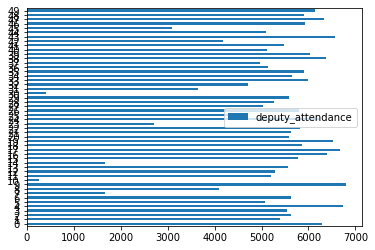

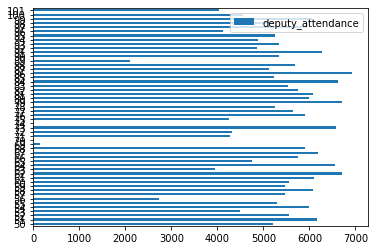

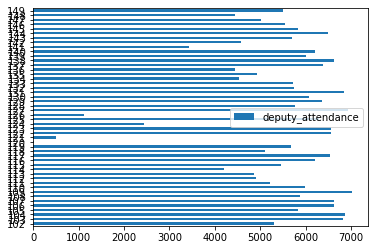

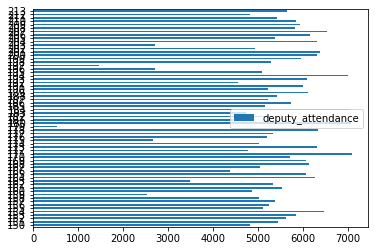

In [14]:
#diagram od deputies attendance total from 2017- 2020 October is divided into 4 pieces in order to make more visible, but I think it didn't help, at least we can see the shape which shows quite varia
deps_attendance_1.plot(kind="barh", fontsize=10)
deps_attendance_2.plot(kind="barh", fontsize=10)
deps_attendance_3.plot(kind="barh", fontsize=10)
deps_attendance_4.plot(kind="barh", fontsize=10)

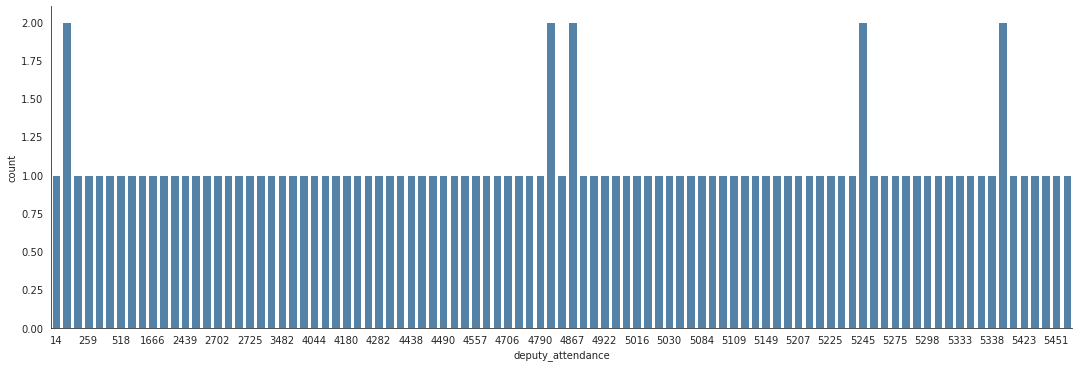

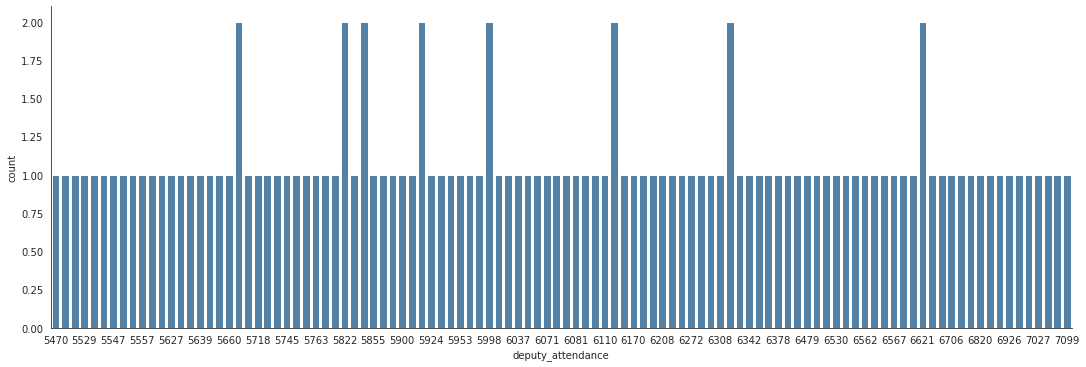

In [15]:
#another diagram to show all numbers of attendance of deputies(x_axis): 
with sns.axes_style('white'):
    g = sns.catplot(x = "deputy_attendance", data=sorted_deps_attendance_total.iloc[:100], aspect=3,
                       kind="count", color='steelblue')
    g.set_xticklabels(step=3)
     
with sns.axes_style('white'):
    g = sns.catplot(x="deputy_attendance", data=sorted_deps_attendance_total.iloc[100:214], aspect=3,
                       kind="count", color='steelblue')
    g.set_xticklabels(step=3)


In [16]:
#In column "deputy_attendance_share" calculated share (in %) of deputy attendance in all events from 2017-2020 October
deputies_attendance_total["deputy_attendance_share"] = (deputies_attendance_total["deputy_attendance"] / total_voteEvents)*100
deputies_attendance_total

,deputies,deputy_attendance,deputy_attendance_share
0,AdamKalous,6290,90.464548
1,AdamVojtěch,5387,77.477348
2,AlenaGajdůšková,5627,80.929095
3,AlexanderČerný,5536,79.620308
4,AlešJuchelka,6728,96.763987
...,...,...,...
209,ZbyněkStanjura,5947,85.531425
210,ZdeněkOndráček,5840,83.992521
211,ZdeněkPodal,5423,77.995110
212,ZuzanaMajerová Zahradníková,4835,69.538329


Text(0, 0.5, 'deputy_attendance_share')

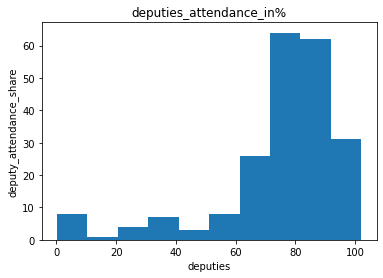

In [17]:
#histogramma shows deps attendance (in %)
deputies_attendance_graph = deputies_attendance_total.drop('deputy_attendance', axis=1)
my_plot = deputies_attendance_graph.plot(kind='hist',legend=None,title="deputies_attendance_in%")
my_plot.set_xlabel("deputies")
my_plot.set_ylabel("deputy_attendance_share")

### Task 2B: Attendance of parliamentary clubs in the votings.
Calculating the number of attendance of clubs and visualization of result

In [20]:
#creating 2 new columns, where "clubsVote_resInt" contains results of votes of each club, and "clubs_vote" = number of vote  on each versions of votes or absence 
data.loc[: ,('vote_result')] = data.groupby(['meeting_no','vote','vote_no','clubs'])['clubs'].transform('count')
data.loc[: ,('clubsVote_resInt')] = data.groupby(['meeting_no','vote_no', 'clubs'])['vote_result'].transform('max')
votes_clubs = data.groupby(['year', 'meeting_no','vote_no','vote_date', 'clubs', 'vote', 'clubsVote_resInt'])["vote_result"].count().rename("clubs_vote").reset_index()
votes_clubs.head(10)

,year,meeting_no,vote_no,vote_date,clubs,vote,clubsVote_resInt,clubs_vote
0,2017,1,2,20. listopadu,ANO,ano,75,75
1,2017,1,2,20. listopadu,ANO,neprihlasen,75,1
2,2017,1,2,20. listopadu,ANO,zdrzel,75,2
3,2017,1,2,20. listopadu,KDU-ČSL,ano,9,9
4,2017,1,2,20. listopadu,KDU-ČSL,zdrzel,9,1
5,2017,1,2,20. listopadu,KSČM,ano,14,14
6,2017,1,2,20. listopadu,KSČM,omluven,14,1
7,2017,1,2,20. listopadu,ODS,ano,25,25
8,2017,1,2,20. listopadu,Piráti,ano,22,22
9,2017,1,2,20. listopadu,SPD,ano,22,22


In [21]:
#in a new column "clubs_decision" in a new dataFrame "votes_clubs" setting up the final decision of club or their absence
votes_clubs = pd.DataFrame(votes_clubs, columns=['year', 'meeting_no','vote_no','vote_date', 'clubs','vote','clubsVote_resInt','clubs_vote'])
votes_clubs['clubs_decision'] = np.where((votes_clubs['clubsVote_resInt'] == votes_clubs['clubs_vote']), votes_clubs['vote'], '0')
votes_clubs

,year,meeting_no,vote_no,vote_date,clubs,vote,clubsVote_resInt,clubs_vote,clubs_decision
0,2017,1,2,20. listopadu,ANO,ano,75,75,ano
1,2017,1,2,20. listopadu,ANO,neprihlasen,75,1,0
2,2017,1,2,20. listopadu,ANO,zdrzel,75,2,0
3,2017,1,2,20. listopadu,KDU-ČSL,ano,9,9,ano
4,2017,1,2,20. listopadu,KDU-ČSL,zdrzel,9,1,0
...,...,...,...,...,...,...,...,...,...
179312,2020,62,235,30. října,TOP09,ano,4,3,0
179313,2020,62,235,30. října,TOP09,omluven,4,4,omluven
179314,2020,62,235,30. října,ČSSD,ano,8,1,0
179315,2020,62,235,30. října,ČSSD,omluven,8,8,omluven


In [22]:
#by applying function "attendance"  in a new column "attendance_clubs" displayed as '1' if decision was 'ano' , "ne", "zdrzel", else Nan 
votes_clubs.loc[:, "attendance_clubs"] = votes_clubs.loc[:, "clubs_decision"].apply(attendance)
votes_clubs

,year,meeting_no,vote_no,vote_date,clubs,vote,clubsVote_resInt,clubs_vote,clubs_decision,attendance_clubs
0,2017,1,2,20. listopadu,ANO,ano,75,75,ano,1.0
1,2017,1,2,20. listopadu,ANO,neprihlasen,75,1,0,NaN
2,2017,1,2,20. listopadu,ANO,zdrzel,75,2,0,NaN
3,2017,1,2,20. listopadu,KDU-ČSL,ano,9,9,ano,1.0
4,2017,1,2,20. listopadu,KDU-ČSL,zdrzel,9,1,0,NaN
...,...,...,...,...,...,...,...,...,...,...
179312,2020,62,235,30. října,TOP09,ano,4,3,0,NaN
179313,2020,62,235,30. října,TOP09,omluven,4,4,omluven,0.0
179314,2020,62,235,30. října,ČSSD,ano,8,1,0,NaN
179315,2020,62,235,30. října,ČSSD,omluven,8,8,omluven,0.0


In [23]:
#clubs_attendance in total is counted by groupping  and summing up column "clubs_attendance" for each club. 
#In a new column "clubs_attendance_share" calculated share (in persentage) of attendance of each club in all vote events from 2017 unrill October 2020
clubs_attendance_total = votes_clubs.groupby(['clubs'])["attendance_clubs"].sum().rename("clubs_attendance").reset_index()
clubs_attendance_total["clubs_attendance_share%"] = (clubs_attendance_total["clubs_attendance"] / total_voteEvents)*100
clubs_attendance_total

,clubs,clubs_attendance,clubs_attendance_share%
0,ANO,6105.0,87.803826
1,KDU-ČSL,6345.0,91.255573
2,KSČM,6145.0,88.379117
3,Nezařaz,3712.0,53.387027
4,ODS,6186.0,88.968790
5,Piráti,6522.0,93.801237
6,SPD,6370.0,91.615130
7,STAN,6301.0,90.622753
8,TOP09,5550.0,79.821660
9,ČSSD,5504.0,79.160075


<AxesSubplot:xlabel='clubs'>

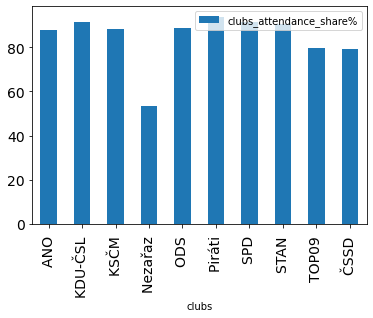

In [29]:
#bar shows deps attendance share  in all vote events (2017-October 2020)
clubs_attendance_graph1 = clubs_attendance_total.drop('clubs_attendance', axis=1)
clubs_attendance_graph1.set_index("clubs", inplace=True)
clubs_attendance_graph1.plot(kind="bar", fontsize=14)

<AxesSubplot:xlabel='clubs'>

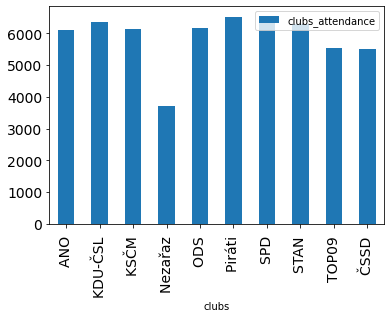

In [30]:
#bar shows deps attendance in number of vote events (2017-October 2020)
clubs_attendance_graph2 = clubs_attendance_total.drop('clubs_attendance_share%', axis=1)
clubs_attendance_graph2.set_index("clubs", inplace=True)
clubs_attendance_graph2.plot(kind="bar", fontsize=14)

### Task#3 How often individual parliamentary clubs vote the same and different:  
  

In [31]:
# Each club decision is goupped and counted  per meeting 
clubs_vote_per_meeting = votes_clubs.groupby(['year', 'meeting_no', 'clubs',  'vote'])["clubs_decision"].count().rename("count_decisions").reset_index()
clubs_vote_per_meeting

,year,meeting_no,clubs,vote,count_decisions
0,2017,1,ANO,ano,13
1,2017,1,ANO,ne,3
2,2017,1,ANO,neprihlasen,10
3,2017,1,ANO,omluven,2
4,2017,1,ANO,zdrzel,12
...,...,...,...,...,...
2571,2020,62,TOP09,zdrzel,69
2572,2020,62,ČSSD,ano,156
2573,2020,62,ČSSD,ne,50
2574,2020,62,ČSSD,omluven,232


In [32]:
#from previous table I took only votes "ano", "ne", "zdrzel"  and created a new table with this data
clubs_vote_per_meeting["clubs_decision_res"] = np.where((clubs_vote_per_meeting["vote"] == "neprihlasen") | (clubs_vote_per_meeting["vote"] == "omluven"), np.nan ,clubs_vote_per_meeting['count_decisions'])
clubs_vote_per_meeting.dropna(inplace=True)
clubs_vote_res = clubs_vote_per_meeting[["meeting_no" ,'clubs', 'vote', 'clubs_decision_res' ]]
clubs_vote_res

,meeting_no,clubs,vote,clubs_decision_res
0,1,ANO,ano,13.0
1,1,ANO,ne,3.0
4,1,ANO,zdrzel,12.0
5,1,KDU-ČSL,ano,14.0
6,1,KDU-ČSL,ne,2.0
...,...,...,...,...
2568,62,TOP09,ne,15.0
2571,62,TOP09,zdrzel,69.0
2572,62,ČSSD,ano,156.0
2573,62,ČSSD,ne,50.0


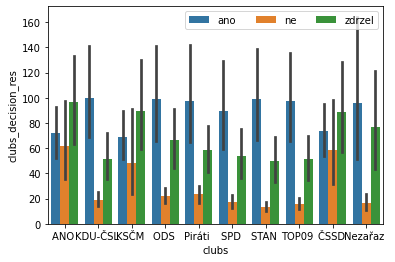

In [33]:
#To show diversity of votes among all clubs I used dataset "diamonds" from seaborn. 
clubs_votes = sns.load_dataset('diamonds')
ax = sns.barplot(x="clubs", y="clubs_decision_res", hue='vote', data=clubs_vote_res)
ax.legend(loc='upper right',ncol=4)

### Task#4 Are deputies in the same parliamentary club voting the same? Who are the biggest rebels?
For this task: 1. Created a new dataFrame to solve this task. 
2.A new column "decision_ofClubs" to assign in words  the result of club's vote
3.A new column "same/diff" assign the result of compariance of deputy vote and his/her club as "same" and "different" 


In [34]:
#1-3
df =  pd.DataFrame(data, columns=['meeting_no','vote_no','vote_date','year','vote_time','agenda','clubs','deputies','vote','attendance_deputies','vote_result','clubsVote_resInt'])
df['decision_ofClubs'] = np.where((df['clubsVote_resInt'] == df['vote_result']), df['vote'], '0')
df['decision_ofClubs'] = np.where((df['clubsVote_resInt'] == df['vote_result']), df['vote'], '0')
df['same/diff'] = np.where((df['decision_ofClubs'] == df['vote']), 'same', 'diff')

In [35]:
#4.Counted all 'same' and 'diff' results of votes on each vote's version  related to each deputy in a new column"same/diff_sum". 
#Assigned Nan values to all rows "neprihlasen and "omluven", then dropped it. 
#Groupped  values of column "same/diff_sum" on each deputy, without vote's version
df_result = df.groupby(["deputies",'vote', 'same/diff'])["same/diff"].count().rename("same/diff_sum").reset_index()
df_result["same/diff_sum"] = np.where((df_result['vote'] == 'neprihlasen') |(df_result['vote'] == 'omluven'), np.nan, df_result['same/diff_sum'])
df_result.dropna(inplace=True)
df_result.head(30)

,deputies,vote,same/diff,same/diff_sum
0,AdamKalous,ano,diff,275.0
1,AdamKalous,ano,same,2600.0
2,AdamKalous,ne,diff,290.0
3,AdamKalous,ne,same,1746.0
8,AdamKalous,zdrzel,diff,685.0
9,AdamKalous,zdrzel,same,694.0
10,AdamVojtěch,ano,diff,102.0
11,AdamVojtěch,ano,same,2175.0
12,AdamVojtěch,ne,diff,101.0
13,AdamVojtěch,ne,same,1710.0


In [36]:
#In order to drop rows "same" and   to sort diff's I created column "rebels", where copied values of diff, and the "same" values  set to Nan value and then dropped it.
#In the end summed up 'diff's'  votes on each deputy, then sorted
df_result["rebels"] = np.where((df_result["same/diff"] == "diff"), df_result["same/diff_sum"], np.nan)
df_result.dropna(inplace=True)
df_result.head(10)
rebels = df_result.groupby(["deputies"])["rebels"].sum().rename("sum_opposite_votes").reset_index()
sorted_rebels = rebels.sort_values(by=("sum_opposite_votes"), ascending=False)
sorted_rebels

,deputies,sum_opposite_votes
72,JiříDolejš,2418.0
143,OndřejVeselý,2215.0
144,PatrikNacher,1835.0
43,JanChvojka,1806.0
197,VojtěchFilip,1639.0
...,...,...
63,JaroslavDvořák,109.0
10,BohuslavSobotka,100.0
119,MartinStropnický,62.0
177,RobertPelikán,39.0


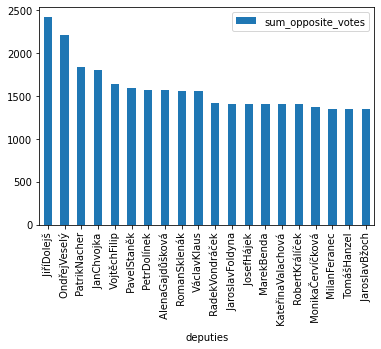

In [37]:
#bar shows the most 20 rebels in voting
sorted_rebels_graph = sorted_rebels.set_index("deputies")
my_plot = sorted_rebels_graph[:20].plot(kind='bar')


### Bonus tasks:

### 1 Visualise some time development in the data (e.g. attendance, change of agreement in voting among individual parliamentary clubs, etc.)

#### Attendance of deputies and clubs during 2017 - 2020 October separately for each year

In [39]:
#calculating the numbers of all vote events for each year separately
df_total_voteEvents_perYear = pd.DataFrame(total_voteEvents_perYear).reset_index()
df_total_voteEvents_perYear

,year,vote_number_total
0,2017,232
1,2018,1602
2,2019,2943
3,2020,2176


In [43]:
#for each year calculating shares of deputies attendance separately, and in the end concatanated all 4 dataframes
deputies_attendance_year = data.groupby(['year','deputies'])["attendance_deputies"].sum().rename("deputy_attendance").reset_index()
deputies_attendance_2017 = deputies_attendance_year[:203]
deputies_attendance_2017.loc[:, ("total_voteEvents")] = 232
deputies_attendance_2017.loc[:, ("share_ofAttendance")] = ((deputies_attendance_2017.loc[:,("deputy_attendance")]) / (deputies_attendance_2017.loc[:, ("total_voteEvents")]))*100
deputies_attendance_2018 = deputies_attendance_year[203:407]
deputies_attendance_2018.loc[:,("total_voteEvents")] = 1602
deputies_attendance_2018.loc[:,("share_ofAttendance")] = ((deputies_attendance_2018.loc[:, ("deputy_attendance")]) / (deputies_attendance_2018.loc[:, ("total_voteEvents")]))*100
deputies_attendance_2019 = deputies_attendance_year[407:612]
deputies_attendance_2019.loc[:,("total_voteEvents")] = 2943
deputies_attendance_2019.loc[:, ("share_ofAttendance")] = ((deputies_attendance_2019.loc[:, ("deputy_attendance")]) / (deputies_attendance_2019.loc[:,("total_voteEvents")]))*100
deputies_attendance_2020 = deputies_attendance_year.loc[612:]
deputies_attendance_2020.loc[:, ("total_voteEvents")] = 2176
deputies_attendance_2020.loc[:, ("share_ofAttendance")] = ((deputies_attendance_2020.loc[:, ("deputy_attendance")] / (deputies_attendance_2020.loc[:, ("total_voteEvents")]))*100)
frames = [deputies_attendance_2017, deputies_attendance_2018, deputies_attendance_2019, deputies_attendance_2020]
result = pd.concat(frames)
result

,year,deputies,deputy_attendance,total_voteEvents,share_ofAttendance
0,2017,AdamKalous,232,232,100.000000
1,2017,AdamVojtěch,226,232,97.413793
2,2017,AlenaGajdůšková,230,232,99.137931
3,2017,AlexanderČerný,225,232,96.982759
4,2017,AlešJuchelka,230,232,99.137931
...,...,...,...,...,...
809,2020,ZbyněkStanjura,1629,2176,74.862132
810,2020,ZdeněkOndráček,1625,2176,74.678309
811,2020,ZdeněkPodal,1130,2176,51.930147
812,2020,ZuzanaMajerová Zahradníková,913,2176,41.957721


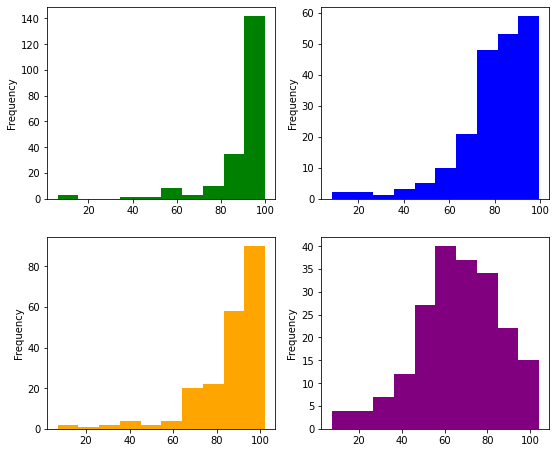

In [44]:
plt.figure(figsize=(9,12)) 

plt.subplot(321) 
deputies_attendance_2017['share_ofAttendance'].plot.hist(color='Green')
plt.subplot(322)
deputies_attendance_2018['share_ofAttendance'].plot.hist(color='Blue')
plt.subplot(323)
deputies_attendance_2019['share_ofAttendance'].plot.hist(color='Orange')
plt.subplot(324)
deputies_attendance_2020['share_ofAttendance'].plot.hist(color='Purple')

plt.show()

<AxesSubplot:xlabel='deputies'>

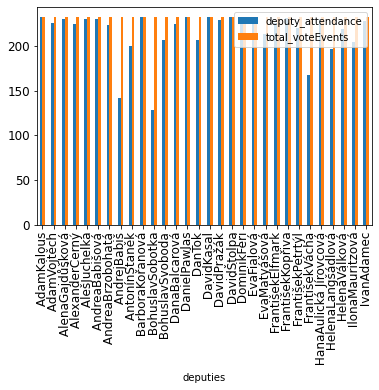

In [45]:
#bar shows deps attendance and number of all vote events (2017). For  readability I showed just data of  30 deputies for 2017
deputies_attendance_2017_graph1 = deputies_attendance_2017.drop('share_ofAttendance', axis=1)
deputies_attendance_2017_graph1.set_index("deputies", inplace=True)
deputies_attendance_2017_graph1[:30].plot(kind="bar", fontsize=12)

In [46]:
#total = data.groupby(['year', 'meeting_no', 'vote_date'])["vote_no"].nunique().rename("vote_number_total").reset_index()
#total_voteEvents_perMeeting = total.groupby(['year', 'meeting_no'])["vote_number_total"].sum()
total_voteEvents_perYear = total.groupby(['year'])["vote_number_total"].sum()
#total_voteEvents_perYear
#total_voteEvents = total["vote_number_total"].sum()
total_voteEvents
total_voteEvents_perYear

year
2017     232
2018    1602
2019    2943
2020    2176
Name: vote_number_total, dtype: int64

In [52]:
clubs_attendance_Year = votes_clubs.groupby(['year', 'clubs'])["attendance_clubs"].sum().rename("clubs_attendance").reset_index()
clubs_attendance_2017 = clubs_attendance_Year[0:9]
clubs_attendance_2017.loc[:,("all_voteEvents")] = 232
clubs_attendance_2017.loc[:, ("share_ofAttendance")] = ((clubs_attendance_2017.loc[:, ("clubs_attendance")]) / (clubs_attendance_2017.loc[:, ("all_voteEvents")]) * 100)
clubs_attendance_2018 = clubs_attendance_Year[9:18]
clubs_attendance_2018.loc[:,("all_voteEvents")] = 1602
clubs_attendance_2018.loc[:, ("share_ofAttendance")] = ((clubs_attendance_2018.loc[:, ("clubs_attendance")]) / (clubs_attendance_2018.loc[:, ("all_voteEvents")]) * 100)

clubs_attendance_2019 = clubs_attendance_Year[18:28]
clubs_attendance_2019.loc[:,("all_voteEvents")] = 2943
clubs_attendance_2019.loc[:, ("share_ofAttendance")] = ((clubs_attendance_2019.loc[:, ("clubs_attendance")]) / (clubs_attendance_2019.loc[:, ("all_voteEvents")]) * 100)

clubs_attendance_2020 = clubs_attendance_Year[28:]
clubs_attendance_2020.loc[:,("all_voteEvents")] = 2176
clubs_attendance_2020.loc[:, ("share_ofAttendance")] = ((clubs_attendance_2020.loc[:, ("clubs_attendance")]) / (clubs_attendance_2020.loc[:, ("all_voteEvents")]) * 100)

clubs_attendance_2020

,year,clubs,clubs_attendance,all_voteEvents,share_ofAttendance
28,2020,ANO,1363.0,2176,62.637868
29,2020,KDU-ČSL,1794.0,2176,82.444853
30,2020,KSČM,1404.0,2176,64.522059
31,2020,Nezařaz,1403.0,2176,64.476103
32,2020,ODS,1526.0,2176,70.128676
33,2020,Piráti,1757.0,2176,80.744485
34,2020,SPD,1658.0,2176,76.194853
35,2020,STAN,1591.0,2176,73.115809
36,2020,TOP09,1034.0,2176,47.518382
37,2020,ČSSD,1189.0,2176,54.641544


<AxesSubplot:>

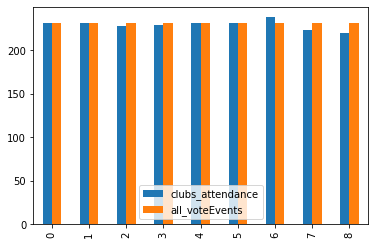

In [53]:
clubs_attendance_2017_graph = clubs_attendance_2017.drop('share_ofAttendance', axis=1)
clubs_attendance_2017_graph.plot(kind="bar", fontsize=10)

<AxesSubplot:>

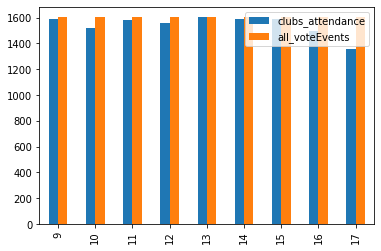

In [54]:
clubs_attendance_2018_graph = clubs_attendance_2018.drop('share_ofAttendance', axis=1)
clubs_attendance_2018_graph.plot(kind="bar", fontsize=10)

<AxesSubplot:>

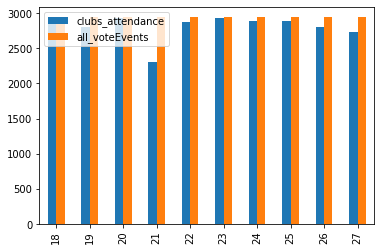

In [55]:
clubs_attendance_2019_graph = clubs_attendance_2019.drop('share_ofAttendance', axis=1)
clubs_attendance_2019_graph.plot(kind="bar", fontsize=10)

<AxesSubplot:>

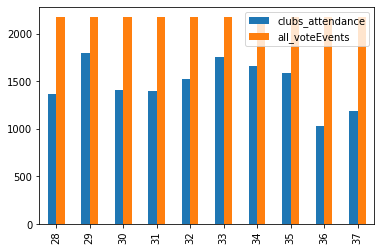

In [56]:
clubs_attendance_2020_graph = clubs_attendance_2020.drop('share_ofAttendance', axis=1)
clubs_attendance_2020_graph.plot(kind="bar", fontsize=10)

In [57]:
frames2 = [clubs_attendance_2017, clubs_attendance_2018, clubs_attendance_2019, clubs_attendance_2020]
result2 = pd.concat(frames2)
result2

,year,clubs,clubs_attendance,all_voteEvents,share_ofAttendance
0,2017,ANO,232.0,232,100.000000
1,2017,KDU-ČSL,231.0,232,99.568966
2,2017,KSČM,228.0,232,98.275862
3,2017,ODS,229.0,232,98.706897
4,2017,Piráti,232.0,232,100.000000
5,2017,SPD,232.0,232,100.000000
6,2017,STAN,238.0,232,102.586207
7,2017,TOP09,223.0,232,96.120690
8,2017,ČSSD,220.0,232,94.827586
9,2018,ANO,1590.0,1602,99.250936


<AxesSubplot:xlabel='clubs'>

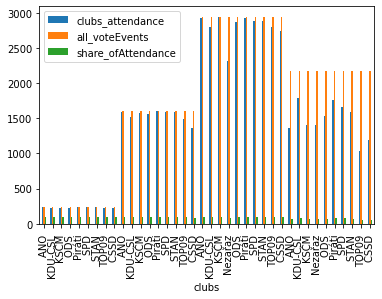

In [58]:
#below 2 bars show the changes in clubs attendance during 2017 - 2020 October
result2_gr = result2.set_index("clubs")
result2_gr.plot(kind="bar", fontsize=10)

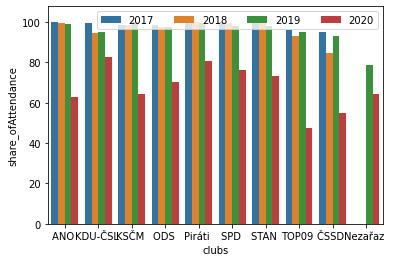

In [59]:
clubs_attendance = sns.load_dataset('diamonds')
ax = sns.barplot(x="clubs", y = "share_ofAttendance", hue='year', data=result2)
ax.legend(loc='upper right',ncol=4)

#### Find individual deputies who have the most similar attendance: 
not solved. I just took data  attendance of deputies per meeting (62 meetings), removed Nan and 0 values, sorted and displayed the max values around 1000. But I didn't take data on each vote to get exact matches of attendance deputies. 
Very interesting to see your solution of this task.

In [224]:
deputies_attendance_meeting = data.groupby(['year','meeting_no', 'deputies'])["attendance_deputies"].sum().rename("deputy_attendance").reset_index()
deps_meeting_duplicates = deputies_attendance_meeting[deputies_attendance_meeting.duplicated([('deputy_attendance')], keep=False)]
deps_meeting_duplicates[('deputy_attendance')] = np.where((deps_meeting_duplicates[("deputy_attendance")] == 0 ), np.nan, deps_meeting_duplicates[('deputy_attendance')])
deps_meeting_duplicates.dropna(inplace=True)
sorted_deps_attendance_meeting = deps_meeting_duplicates.sort_values(by=("deputy_attendance"), ascending=False)
sorted_deps_attendance_meeting.head(80)


<ipython-input-224-9bfbb5813e1c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deps_meeting_duplicates[('deputy_attendance')] = np.where((deps_meeting_duplicates[("deputy_attendance")] == 0 ), np.nan, deps_meeting_duplicates[('deputy_attendance')])
<ipython-input-224-9bfbb5813e1c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deps_meeting_duplicates.dropna(inplace=True)


,year,meeting_no,deputies,deputy_attendance
5362,2019,30,RadekRozvoral,1071.0
5282,2019,30,KamalFarhan,1071.0
5325,2019,30,MiloslavaRutová,1071.0
5370,2019,30,RomanKubíček,1071.0
5224,2019,30,FrantišekPetrtýl,1071.0
...,...,...,...,...
5317,2019,30,MikulášFerjenčík,1054.0
5388,2019,30,VojtěchFilip,1044.0
5213,2019,30,DanaBalcarová,1044.0
5372,2019,30,RomanSklenák,1043.0


In [218]:
deputies_attendance_vote = data.groupby(['year','meeting_no', 'vote_no','deputies'])["attendance_deputies"].sum().rename("deputy_attendance").reset_index()
deps_vote_duplicates = deputies_attendance_vote[deputies_attendance_vote.duplicated(['deputies'], keep=False)]
deps_vote_duplicates.loc[:,('deputy_attendance')] = np.where((deps_vote_duplicates.loc[: ,("deputy_attendance")] == 0 ), np.nan, deps_vote_duplicates.loc[:, ('deputy_attendance')])
deps_vote_duplicates.sort_values(by=("deputy_attendance"))
deps_vote_duplicates.dropna(inplace=True)
deps_vote_duplicates

,year,meeting_no,vote_no,deputies,deputy_attendance
0,2017,1,2,AdamKalous,1.0
1,2017,1,2,AdamVojtěch,1.0
2,2017,1,2,AlenaGajdůšková,1.0
3,2017,1,2,AlexanderČerný,1.0
4,2017,1,2,AlešJuchelka,1.0
...,...,...,...,...,...
1388998,2020,62,235,VítKaňkovský,1.0
1388999,2020,62,235,VítRakušan,1.0
1389001,2020,62,235,VěraKovářová,1.0
1389006,2020,62,235,ZuzanaMajerová Zahradníková,1.0
